I am working individually

# I created a blackjack game to generate the data for my models.

In [19]:
# Blackjack Game for data collection

import random

random.seed(42)

# Define card suits and ranks
suits = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
ranks = {
    '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7,
    '8': 8, '9': 9, '10': 10, 'Jack': 10, 'Queen': 10,
    'King': 10, 'Ace': 11  # Ace is counted as 11 initially
}

class Card:
    def __init__(self, suit, rank):
        self.suit = suit
        self.rank = rank

    def __str__(self):
        return f'{self.rank} of {self.suit}'

    def value(self):
        return ranks[self.rank]

class Deck:
    def __init__(self):
        self.cards = [Card(suit, rank) for suit in suits for rank in ranks]
        random.shuffle(self.cards)

    def deal_card(self):
        if len(self.cards) == 0:
            # Reinitialize the deck if all cards have been dealt
            self.__init__()
        return self.cards.pop()

class Hand:
    def __init__(self):
        self.cards = []
        self.total = 0
        self.soft_aces = 0  # Number of aces counted as 11

    def add_card(self, card):
        self.cards.append(card)
        self.total += card.value()
        if card.rank == 'Ace':
            self.soft_aces += 1  # Initially count Ace as 11
        self.adjust_for_ace()

    def adjust_for_ace(self):
        # Adjust for aces if total is over 21
        while self.total > 21 and self.soft_aces > 0:
            self.total -= 10  # Counting one Ace as 1 instead of 11
            self.soft_aces -= 1

    def is_soft(self):
        # A hand is soft if there are any aces counted as 11
        return self.soft_aces > 0

    def can_split(self):
        return len(self.cards) == 2 and self.cards[0].rank == self.cards[1].rank

    def __str__(self):
        return ', '.join(str(card) for card in self.cards)

# Basic strategy based on standard blackjack strategy charts
def basic_strategy(player_hand, dealer_upcard_value):
    player_total = player_hand.total
    dealer_card = dealer_upcard_value
    is_soft = player_hand.is_soft()
    can_split = player_hand.can_split()
    
    # Pair Splitting Strategy
    if can_split:
        pair_rank = player_hand.cards[0].rank
        # Map face cards to '10'
        if pair_rank in ['Jack', 'Queen', 'King']:
            pair_rank = '10'
        elif pair_rank == 'Ace':
            pair_rank = 'A'

        # Define splitting decisions
        split_decisions = {
            'A': 'Split',
            '8': 'Split',
            '10': 'Stand',
            '9': 'Split' if dealer_card not in [7, 10, 11] else 'Stand',
            '7': 'Split' if dealer_card in range(2, 8) else 'Hit',
            '6': 'Split' if dealer_card in range(2, 7) else 'Hit',
            '5': 'Double Down' if dealer_card in range(2, 10) else 'Hit',
            '4': 'Split' if dealer_card in [5, 6] else 'Hit',
            '3': 'Split' if dealer_card in range(2, 8) else 'Hit',
            '2': 'Split' if dealer_card in range(2, 8) else 'Hit',
        }

        action = split_decisions.get(pair_rank, 'Hit')
        return action
    
    # Soft Totals Strategy
    if is_soft:
        if player_total >= 19:
            return 'Stand'
        elif player_total == 18:
            if dealer_card in range(2, 9):  # Dealer shows 2-8
                return 'Stand'
            elif dealer_card == 9 or dealer_card == 10 or dealer_card == 11:
                return 'Hit'
            else:
                return 'Hit'
        elif player_total == 17:
            if dealer_card in range(3, 7):  # Dealer shows 3-6
                return 'Double Down'
            else:
                return 'Hit'
        elif player_total in [15, 16]:
            if dealer_card in range(4, 7):  # Dealer shows 4-6
                return 'Double Down'
            else:
                return 'Hit'
        elif player_total in [13, 14]:
            if dealer_card in range(5, 7):  # Dealer shows 5-6
                return 'Double Down'
            else:
                return 'Hit'
        else:
            return 'Hit'
    
    # Hard Totals Strategy
    if player_total >= 17:
        return 'Stand'
    elif player_total == 16 or player_total == 15:
        if dealer_card in range(2, 7):  # Dealer shows 2-6
            return 'Stand'
        else:
            return 'Hit'
    elif player_total == 14 or player_total == 13:
        if dealer_card in range(2, 7):  # Dealer shows 2-6
            return 'Stand'
        else:
            return 'Hit'
    elif player_total == 12:
        if dealer_card in range(4, 7):  # Dealer shows 4-6
            return 'Stand'
        else:
            return 'Hit'
    elif player_total == 11:
        return 'Double Down'
    elif player_total == 10:
        if dealer_card in range(2, 10):  # Dealer shows 2-9
            return 'Double Down'
        else:
            return 'Hit'
    elif player_total == 9:
        if dealer_card in range(3, 7):  # Dealer shows 3-6
            return 'Double Down'
        else:
            return 'Hit'
    else:
        return 'Hit'

def play_blackjack(game_data):
    # Initialize deck and hands
    deck = Deck()
    player_hand = Hand()
    dealer_hand = Hand()

    # Deal initial cards
    player_hand.add_card(deck.deal_card())
    dealer_hand.add_card(deck.deal_card())
    player_hand.add_card(deck.deal_card())
    dealer_hand.add_card(deck.deal_card())

    # Get dealer's upcard value
    dealer_upcard_value = dealer_hand.cards[0].value()
    if dealer_hand.cards[0].rank == 'Ace':
        dealer_upcard_value = 11  # Ace is 11

    # Collect data for the initial hand
    action = basic_strategy(player_hand, dealer_upcard_value)
    game_state = {
        'Player Total': player_hand.total,
        'Dealer Upcard': dealer_upcard_value,
        'Has Ace': int(player_hand.is_soft()),  # Convert boolean to integer (0 or 1)
        'Recommended Action': action
    }
    game_data.append(game_state)

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize data collection list
game_data = []

# Number of simulations
num_simulations = 50000

# Run simulations
for _ in range(num_simulations):
    play_blackjack(game_data)

# Save data to CSV
dframe = pd.DataFrame(game_data)
dframe.to_csv('blackjack_simulation_data.csv', index=False)

**Now that I have ran the simulated game 50,000 times and saved the data, I can now begin the data preprocessing**

**First, I read in the csv to a pandas dataframe and print the head.**

In [21]:
# Load the data
df = pd.read_csv('blackjack_simulation_data.csv')

df.head()

,Player Total,Dealer Upcard,Has Ace,Recommended Action
0,6,9,0,Hit
1,20,7,0,Stand
2,10,10,0,Hit
3,12,5,0,Stand
4,15,9,1,Hit


**Second, I decided to check for any missing values.**

In [22]:
# Check for missing values
print(df.isnull().sum())

Player Total          0
Dealer Upcard         0
Has Ace               0
Recommended Action    0
dtype: int64


**Third, I encoded the recommended action so that it would be easier to work with later in the program.**

In [23]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform the 'Recommended Action' column
df['Action_Code'] = le.fit_transform(df['Recommended Action'])

# Map the encoded classes
action_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Action Mapping:", action_mapping)

Action Mapping: {'Double Down': 0, 'Hit': 1, 'Split': 2, 'Stand': 3}


**Fourth, I decided to plot some different aspects of the dataset to get a better understanding of the data I had collected.**

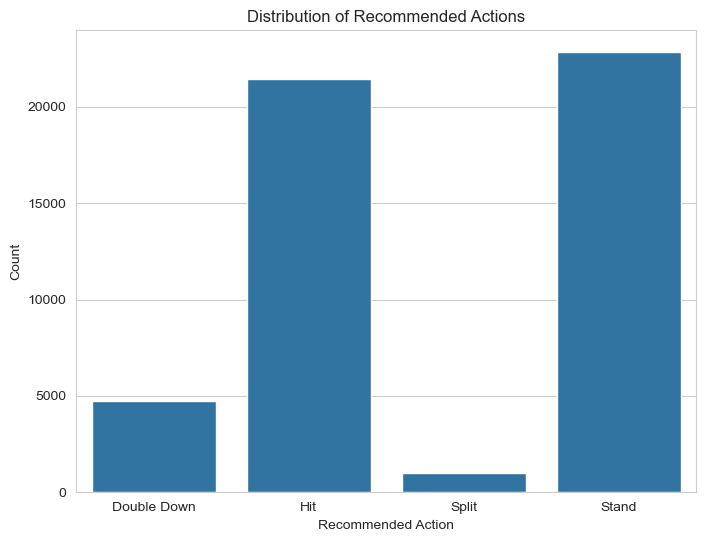

In [24]:
# Set the aesthetic style of the plots
sns.set_style('whitegrid')

# Plot the distribution of recommended actions
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='Recommended Action', order=le.classes_)
plt.title('Distribution of Recommended Actions')
plt.xlabel('Recommended Action')
plt.ylabel('Count')
plt.show()

This first plot shows the distribution of recommended actions, and the results make sense because the player should only double or split in specific scenarios, whereas hitting or standing are common moves.

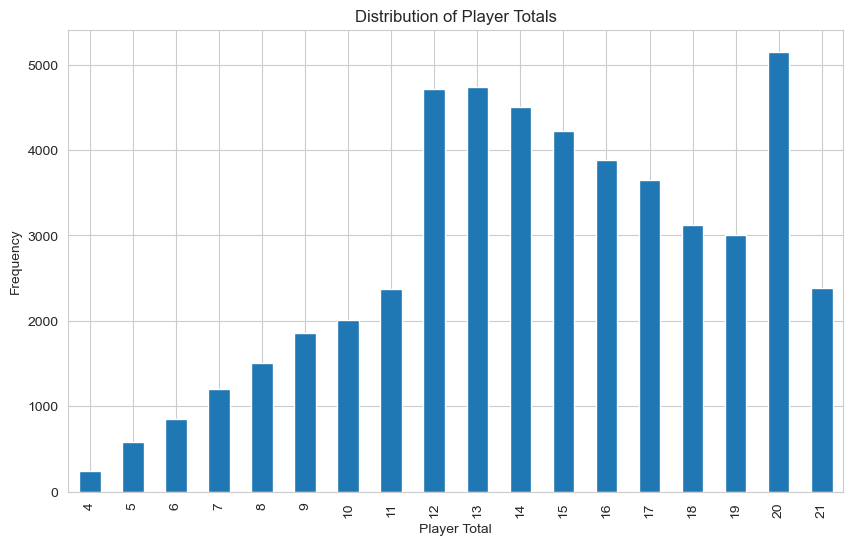

In [25]:
# Plot the distribution of player totals
plt.figure(figsize=(10,6))
df['Player Total'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Player Total')
plt.ylabel('Frequency')
plt.title('Distribution of Player Totals')
plt.show()

This second plot shows the distribution of player totals when dealt 2 cards. Since my simulated game is using a single deck of cards, there are four cards that have value 10 (10, Jack, Queen, King) so it makes sense that the results should be more spread across the higher values. As seen in the image below 12-14 should have the highest probability of occuring, other than 20 which has over a 10% chance of being dealt.

![Title](img/cardProbabilities.png)

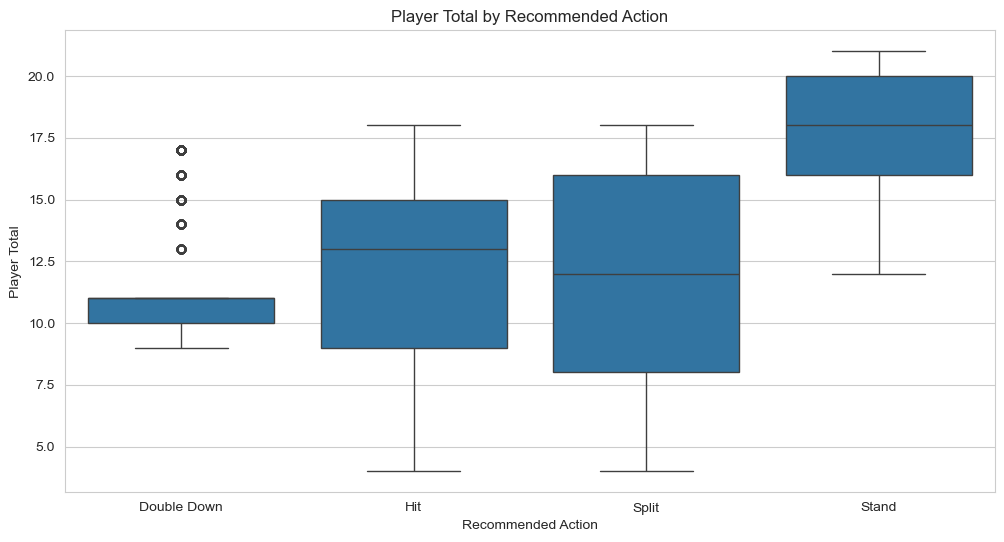

In [26]:
# Plot of Player Total by Recommended Action
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='Recommended Action', y='Player Total', order=le.classes_)
plt.title('Player Total by Recommended Action')
plt.xlabel('Recommended Action')
plt.ylabel('Player Total')
plt.show()

This third plot shows the distribution of player total based on the recommended action. The purpose of this graph was to better understand where each action is being recommended the most. For example, we can see that doubling down is most recommended when the player has 10 or 11 but is not suggested in many other cases. On the other hand, hitting occurs from 4-18 with the inner quartile range being from 9-15.

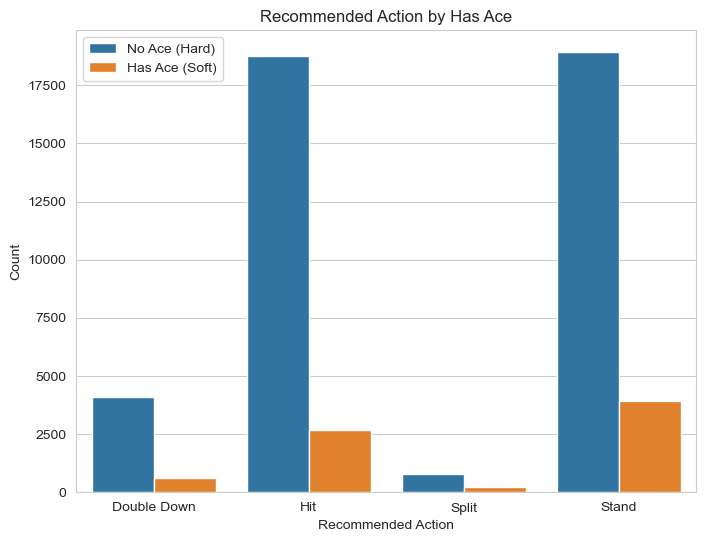

In [27]:
# Plot of Recommended Action by having an ace
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='Recommended Action', hue='Has Ace', order=le.classes_)
plt.title('Recommended Action by Has Ace')
plt.xlabel('Recommended Action')
plt.ylabel('Count')
plt.legend(labels=['No Ace (Hard)', 'Has Ace (Soft)'])
plt.show()

This fourth plot shows the recommended action similarly to the first plot, but also includes whether the player has an ace or not. I was curious to see if there would be a significant change in recommended action based on the case of an ace, but the results have a similar distribution regardless of the ace.

**Fifth, now that I am better able to understand the data I moved into setting up the train/test split and scaling the data as seen below.**

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

# Features and target variable
X = df[['Player Total', 'Dealer Upcard', 'Has Ace']]
y = df['Action_Code']

# Split the data (using stratify to maintain class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [29]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit on training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data
X_test_scaled = scaler.transform(X_test)

**Splitting and scaling the data is completed and now I started setting up each of my models and checking their accuracy.**

# Logistic regression

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
    'penalty': ['l2'],
    'max_iter': [100, 200, 500]
}

# Initialize the Logistic Regression model
logreg = LogisticRegression(multi_class='multinomial', random_state=42,)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
best_params_logreg = grid_search.best_params_
print("Best Hyperparameters for Logistic Regression:", best_params_logreg)

# Predict on test data using the best model
best_logreg = grid_search.best_estimator_
y_pred_logreg = best_logreg.predict(X_test_scaled)

# Accuracy
acc_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Logistic Regression Accuracy: {acc_logreg:.6f}")

# Classification Report
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_logreg, target_names=le.classes_, zero_division=0))

Best Hyperparameters for Logistic Regression: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Logistic Regression Accuracy: 0.803000
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

 Double Down       0.32      0.09      0.14       945
         Hit       0.75      0.86      0.80      4287
       Split       0.00      0.00      0.00       202
       Stand       0.88      0.94      0.91      4566

    accuracy                           0.80     10000
   macro avg       0.49      0.47      0.46     10000
weighted avg       0.75      0.80      0.77     10000



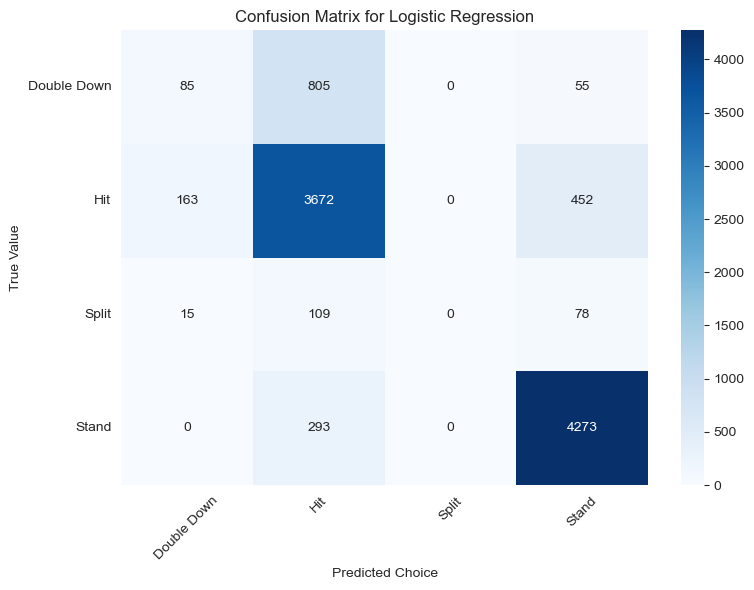

In [31]:
# Compute Confusion Matrix for Logistic Regression
cm_logreg = confusion_matrix(y_test, y_pred_logreg)

# Plot Confusion Matrix using Seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted Choice')
plt.ylabel('True Value')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

The Logistic Regression model achieved an accuracy of 80.3%, significantly lower than the other models. It performed well on the ‘Stand’ class (precision: 88%, recall: 94%) and moderately on ‘Hit’ (precision: 75%, recall: 86%). However, it struggled with ‘Double Down’ (precision: 32%, recall: 9%) and failed to predict any ‘Split’ instances correctly (precision and recall: 0%). This indicates difficulties in handling class imbalance and capturing complex patterns inherent in the data.

# K Nearest Neighbors

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize the KNN model
knn = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
best_params_knn = grid_search.best_params_
print("Best Hyperparameters for KNN:", best_params_knn)

# Predict on test data using the best model
best_knn = grid_search.best_estimator_
y_pred_knn = best_knn.predict(X_test_scaled)

# Accuracy
acc_knn = accuracy_score(y_test, y_pred_knn)
print(f"K-Nearest Neighbors Accuracy: {acc_knn:.6f}")

# Classification Report
print("Classification Report for K-Nearest Neighbors:")
print(classification_report(y_test, y_pred_knn, target_names=le.classes_))

Best Hyperparameters for KNN: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
K-Nearest Neighbors Accuracy: 0.987000
Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

 Double Down       1.00      1.00      1.00       945
         Hit       0.99      1.00      0.99      4287
       Split       1.00      0.36      0.53       202
       Stand       0.98      1.00      0.99      4566

    accuracy                           0.99     10000
   macro avg       0.99      0.84      0.88     10000
weighted avg       0.99      0.99      0.98     10000



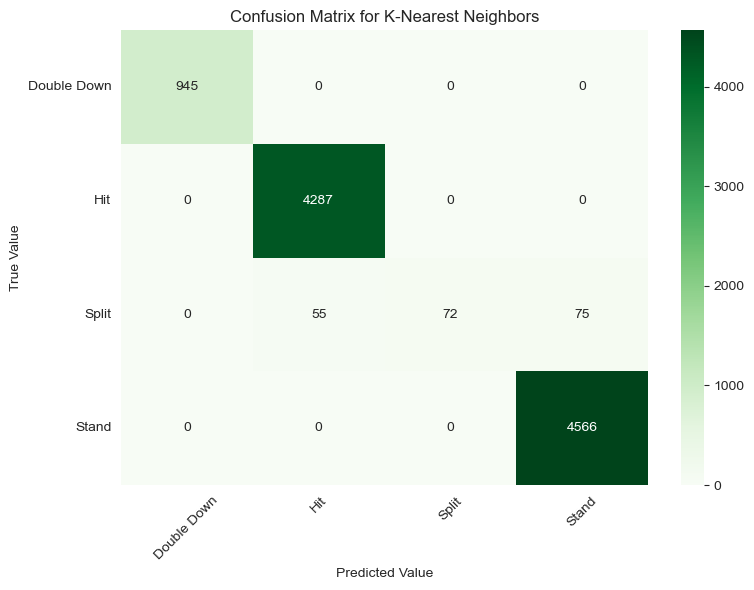

In [33]:
# Compute Confusion Matrix for K-Nearest Neighbors
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Plot Confusion Matrix using Seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for K-Nearest Neighbors')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

The KNN model achieved a high accuracy of 98.7% using the Euclidean metric with 9 neighbors and distance weighting. It performed exceptionally well on ‘Double Down’, ‘Hit’, and ‘Stand’ classes, with near-perfect precision and recall. For the ‘Split’ class, it had perfect precision (100%) but low recall (36%), suggesting that while ‘Split’ predictions were always correct, the model missed many actual ‘Split’ instances.

# Decision Tree

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params_dt = grid_search.best_params_
print("Best Hyperparameters for Decision Tree:", best_params_dt)

# Predict on test data using the best model
best_dt = grid_search.best_estimator_
y_pred_dt = best_dt.predict(X_test)

# Accuracy
acc_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {acc_dt:.6f}")

# Classification Report
print("Classification Report for Decision Tree:")
print(classification_report(y_test, y_pred_dt, target_names=le.classes_))

Best Hyperparameters for Decision Tree: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}
Decision Tree Accuracy: 0.987000
Classification Report for Decision Tree:
              precision    recall  f1-score   support

 Double Down       1.00      1.00      1.00       945
         Hit       0.99      1.00      0.99      4287
       Split       1.00      0.36      0.53       202
       Stand       0.98      1.00      0.99      4566

    accuracy                           0.99     10000
   macro avg       0.99      0.84      0.88     10000
weighted avg       0.99      0.99      0.98     10000



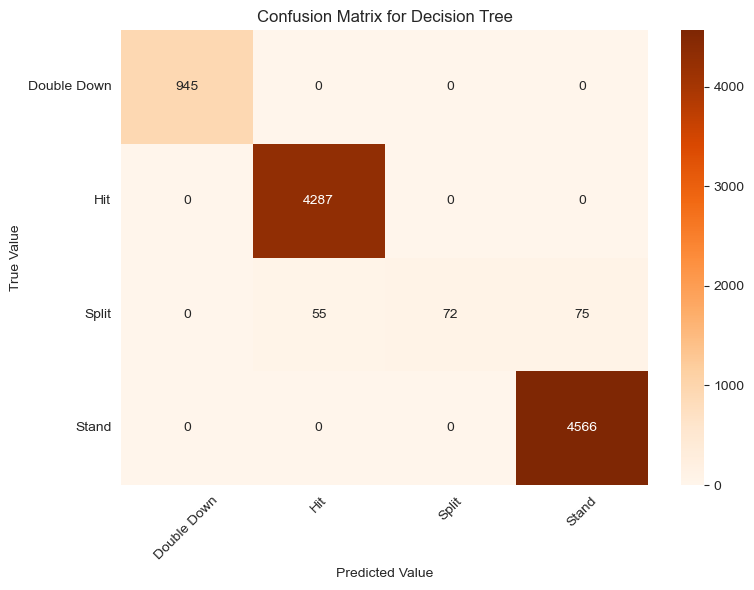

In [35]:
# Compute Confusion Matrix for Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Plot Confusion Matrix using Seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Oranges', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for Decision Tree')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

With an accuracy of 98.7%, the Decision Tree model excelled in predicting ‘Double Down’, ‘Hit’, and ‘Stand’ classes, achieving almost perfect precision and recall. For the ‘Split’ class, it had perfect precision (100%) but low recall (36%), indicating that while its ‘Split’ predictions were accurate, it failed to identify a significant portion of actual ‘Split’ cases.

# Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt']
}

# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=10, cv=5, n_jobs=-1, scoring='accuracy', random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Best hyperparameters
best_params_rf = random_search.best_params_
print("Best Hyperparameters for Random Forest:", best_params_rf)

# Predict on test data using the best model
best_rf = random_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Accuracy
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {acc_rf:.6f}")

# Classification Report
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

Best Hyperparameters for Random Forest: {'n_estimators': 500, 'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 20}
Random Forest Accuracy: 0.987000
Classification Report for Random Forest:
              precision    recall  f1-score   support

 Double Down       1.00      1.00      1.00       945
         Hit       0.99      1.00      0.99      4287
       Split       1.00      0.36      0.53       202
       Stand       0.98      1.00      0.99      4566

    accuracy                           0.99     10000
   macro avg       0.99      0.84      0.88     10000
weighted avg       0.99      0.99      0.98     10000



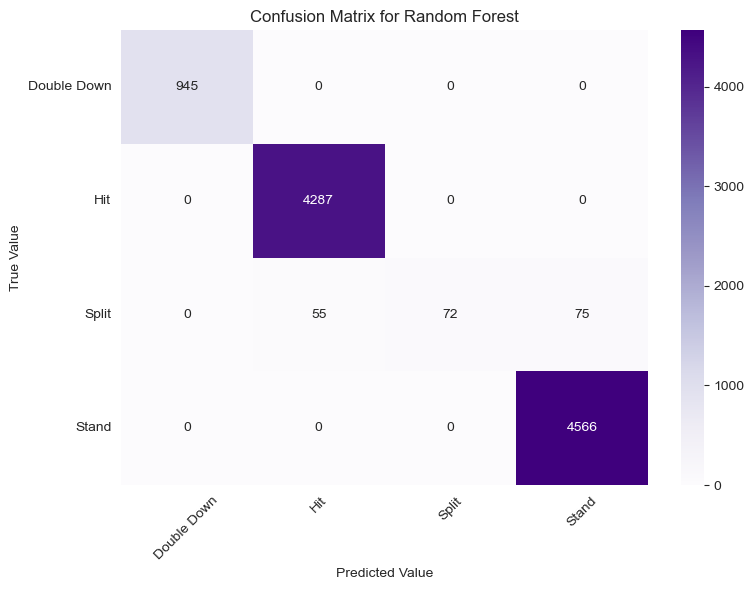

In [37]:
# Compute Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot Confusion Matrix using Seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Purples', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Also achieving 98.7% accuracy, the Random Forest model mirrored the Decision Tree’s performance. It showed outstanding results on ‘Double Down’, ‘Hit’, and ‘Stand’ classes. However, it shared the same issue with the ‘Split’ class—perfect precision (100%) but low recall (36%)—highlighting consistent challenges in capturing this minority class despite using an ensemble approach.

# SVM (Support Vector Machine)

In [38]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Define the parameter grid
param_grid = {
    'rbf__gamma': [0.1, 1, 10],
    'rbf__n_components': [100, 500, 1000],
    'sgd__alpha': [0.0001, 0.001, 0.01],
    'sgd__penalty': ['l2', 'l1', 'elasticnet']
}

# Create a pipeline
pipeline = Pipeline([
    ('rbf', RBFSampler(random_state=42)),
    ('sgd', SGDClassifier(max_iter=1000, tol=1e-3, random_state=42))
])

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
best_params_svm = grid_search.best_params_
print("Best Hyperparameters for SVM with Kernel Approximation:", best_params_svm)

# Predict on test data using the best model
best_svm = grid_search.best_estimator_
y_pred_kernel_approx = best_svm.predict(X_test_scaled)

# Accuracy
acc_kernel_approx = accuracy_score(y_test, y_pred_kernel_approx)
print(f"SVM with Kernel Approximation Accuracy: {acc_kernel_approx:.6f}")

# Classification Report
print("Classification Report for SVM with Kernel Approximation:")
print(classification_report(y_test, y_pred_kernel_approx, target_names=le.classes_))

Best Hyperparameters for SVM with Kernel Approximation: {'rbf__gamma': 10, 'rbf__n_components': 500, 'sgd__alpha': 0.0001, 'sgd__penalty': 'l2'}
SVM with Kernel Approximation Accuracy: 0.987000
Classification Report for SVM with Kernel Approximation:
              precision    recall  f1-score   support

 Double Down       1.00      1.00      1.00       945
         Hit       0.99      1.00      0.99      4287
       Split       1.00      0.36      0.53       202
       Stand       0.98      1.00      0.99      4566

    accuracy                           0.99     10000
   macro avg       0.99      0.84      0.88     10000
weighted avg       0.99      0.99      0.98     10000



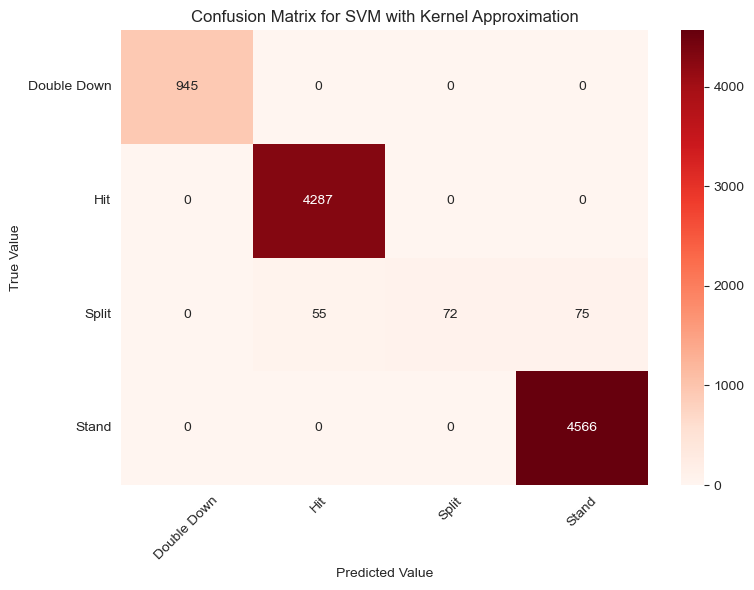

In [39]:
# Compute Confusion Matrix for SVM with Kernel Approximation
cm_svm = confusion_matrix(y_test, y_pred_kernel_approx)

# Plot Confusion Matrix using Seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Reds', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for SVM with Kernel Approximation')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

The SVM model reached an accuracy of 98.7%, performing exceptionally on ‘Double Down’, ‘Hit’, and ‘Stand’ classes with near-perfect metrics. Similar to previous models, it had perfect precision (100%) but low recall (36%) for the ‘Split’ class, indicating a tendency to miss many actual instances of ‘Split’ despite being correct when it did predict them.

# Neural Network (MLPClassifier)

In [40]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define the parameter distribution
param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 25)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01],
    'early_stopping': [True],
}

# Initialize the MLPClassifier
mlp = MLPClassifier(max_iter=500, random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=mlp, param_distributions=param_dist, n_iter=10, cv=3, n_jobs=-1, scoring='accuracy', random_state=42)

# Fit the model
random_search.fit(X_train_scaled, y_train)

# Best hyperparameters
best_params_mlp = random_search.best_params_
print("Best Hyperparameters for Neural Network (MLP):", best_params_mlp)

# Predict on test data using the best model
best_mlp = random_search.best_estimator_
y_pred_mlp = best_mlp.predict(X_test_scaled)

# Accuracy
acc_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"Neural Network (MLP) Accuracy: {acc_mlp:.6f}")

# Classification Report
print("Classification Report for Neural Network (MLP):")
print(classification_report(y_test, y_pred_mlp, target_names=le.classes_))

Best Hyperparameters for Neural Network (MLP): {'solver': 'adam', 'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50, 25), 'early_stopping': True, 'alpha': 0.001, 'activation': 'tanh'}
Neural Network (MLP) Accuracy: 0.987000
Classification Report for Neural Network (MLP):
              precision    recall  f1-score   support

 Double Down       1.00      1.00      1.00       945
         Hit       0.99      1.00      0.99      4287
       Split       1.00      0.36      0.53       202
       Stand       0.98      1.00      0.99      4566

    accuracy                           0.99     10000
   macro avg       0.99      0.84      0.88     10000
weighted avg       0.99      0.99      0.98     10000



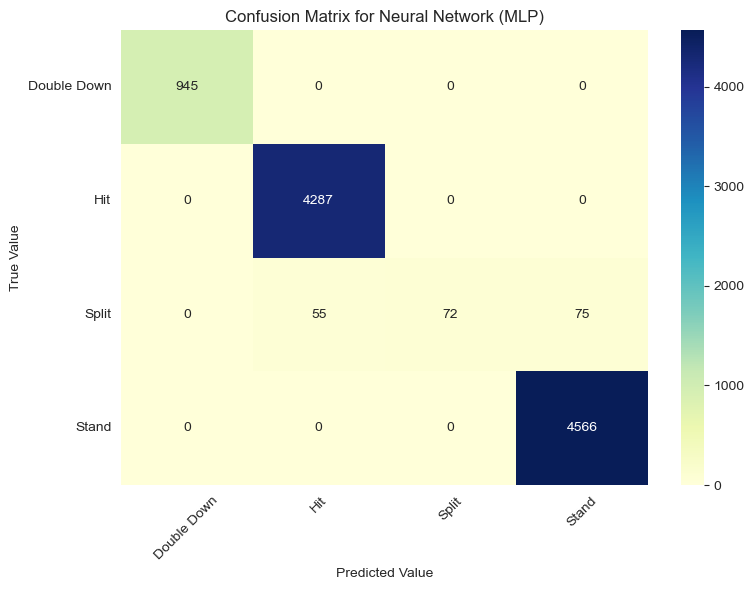

In [41]:
# Compute Confusion Matrix for Neural Network (MLP)
cm_mlp = confusion_matrix(y_test, y_pred_mlp)

# Plot Confusion Matrix using Seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='YlGnBu', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for Neural Network (MLP)')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

The Neural Network achieved an accuracy of 98.7%, matching the top-performing models. It maintained excellent performance on ‘Double Down’, ‘Hit’, and ‘Stand’ classes. However, for the ‘Split’ class, it had perfect precision (100%) but low recall (36%), suggesting difficulty in accurately identifying all ‘Split’ instances similar to other models.

# Accuracy Comparison across all the models

In [42]:
# Collect accuracies
model_accuracies = {
    'Logistic Regression': acc_logreg,
    'K-Nearest Neighbors': acc_knn,
    'Decision Tree': acc_dt,
    'Random Forest': acc_rf,
    'Support Vector Machine': acc_kernel_approx,
    'Neural Network (MLP)': acc_mlp
}

# Create a DataFrame for comparison
accuracy_df = pd.DataFrame(list(model_accuracies.items()), columns=['Model', 'Accuracy'])

# Sort by 'Accuracy' in descending order and reset the index
accuracy_df = accuracy_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# Add a Rank column starting from 1
accuracy_df.index += 1
accuracy_df.index.name = 'Rank'

# Format the 'Accuracy' column as percentages
accuracy_df['Accuracy'] = (accuracy_df['Accuracy'] * 100).round(3).astype(str) + '%'

# Display the DataFrame
print(accuracy_df)

                       Model Accuracy
Rank                                 
1        K-Nearest Neighbors    98.7%
2              Decision Tree    98.7%
3              Random Forest    98.7%
4     Support Vector Machine    98.7%
5       Neural Network (MLP)    98.7%
6        Logistic Regression    80.3%


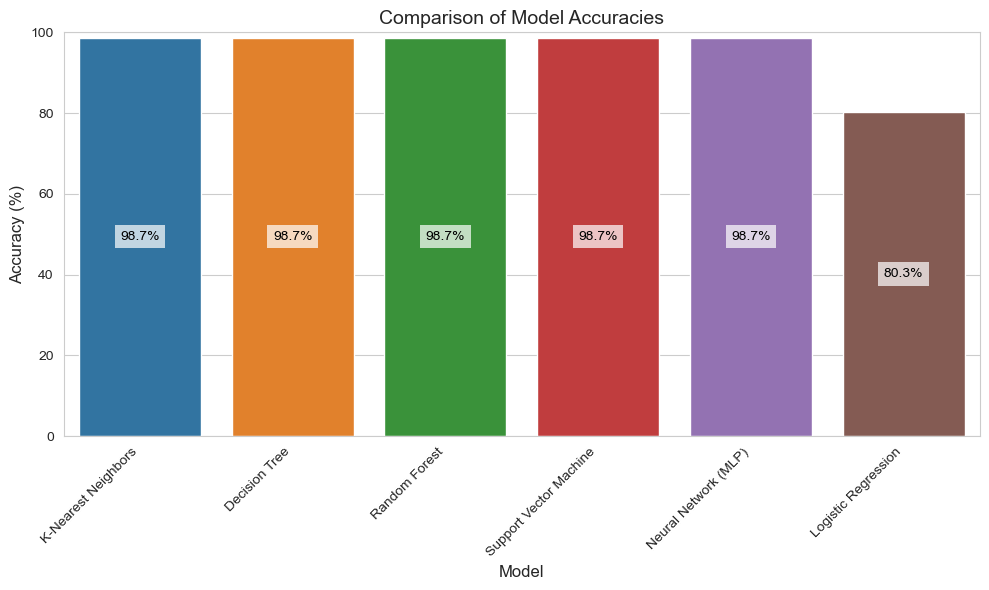

In [43]:
# Since the 'Accuracy' column is formatted as a string with '%', I need to convert it back to a numeric value for plotting
accuracy_df['Accuracy_Num'] = accuracy_df['Accuracy'].str.rstrip('%').astype('float')

# Ensure the bars are plotted in the same order as in accuracy_df
plt.figure(figsize=(10,6))
ax = sns.barplot(x='Model', y='Accuracy_Num', data=accuracy_df, hue='Model', legend=False, order=accuracy_df['Model'])

# Accuracy values inside the bars
for index, p in enumerate(ax.patches):
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2
    text = accuracy_df.iloc[index]['Accuracy']
    ax.text(x, height / 2, text, ha='center', va='center', color='black',
            fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Customize the plot
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Comparison of Model Accuracies', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.tight_layout()

# Show the plot
plt.show()

Across all models except Logistic Regression, there was consistently high accuracy (98.7%) on the majority classes—‘Double Down’, ‘Hit’, and ‘Stand’—with near-perfect precision and recall. The common challenge was the ‘Split’ class, where all models exhibited low recall despite perfect precision. This pattern indicates a significant class imbalance affecting the minority class prediction. Addressing this imbalance through techniques like class weighting or oversampling could potentially improve model performance on the ‘Split’ class. When I implimented this it did increase accuracy on the split class, but decreased overall accuracy by 10-15% so I decided to remove it.